In [1]:
import functools
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
from flax import linen as nn
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.networks.layers import time_encoder
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

from ot_pert.metrics import compute_mean_metrics, compute_metrics_fast
from ot_pert.utils import ConditionalLoader
from ot_pert.nets.nets import CondVelocityField

In [2]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

In [3]:
obsm_key_cond = "ecfp_dose_cell_line"
obsm_key_data = "X_pca"

In [4]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_30.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_30.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_30.h5ad"

In [5]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
sc.pp.subsample(adata_train, fraction=0.1)

In [7]:
adata_train.obsm["ecfp_dose"] = np.concatenate(
    (adata_train.obsm["ecfp"], np.asarray(adata_train.obs["dose"])[:, None]), axis=1
)
adata_test.obsm["ecfp_dose"] = np.concatenate(
    (adata_test.obsm["ecfp"], np.asarray(adata_test.obs["dose"])[:, None]), axis=1
)
adata_ood.obsm["ecfp_dose"] = np.concatenate(
    (adata_ood.obsm["ecfp"], np.asarray(adata_ood.obs["dose"])[:, None]), axis=1
)

In [8]:
adata_train.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_train.obsm["ecfp_dose"], adata_train.obsm["cell_line_emb"]), axis=1
)
adata_test.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_test.obsm["ecfp_dose"], adata_test.obsm["cell_line_emb"]), axis=1
)
adata_ood.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_ood.obsm["ecfp_dose"], adata_ood.obsm["cell_line_emb"]), axis=1
)

In [9]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
    epsilon: float = 1e-2,
    tau_a: float = 1.0,
    tau_b: float = 1.0,
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(
            x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b
        )
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
    raise NotImplementedError(f"Unknown type: {typ}.")


# Load data

dls = []

train_data_source = {}
train_data_target = {}
train_data_source_decoded = {}
train_data_target_decoded = {}
train_data_conditions = {}


for cond in adata_train.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_train[adata_train.obs["condition"] == cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_train[adata_train.obs["condition"] == src_str[0] + "_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_train[adata_train.obs["condition"] == src_str[0] + "_Vehicle_0.0"].X.A
    target = adata_train[adata_train.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_train[adata_train.obs["condition"] == cond].X.A
    conds = adata_train[adata_train.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    dls.append(
        DataLoader(
            datasets.OTDataset(
                datasets.OTData(
                    lin=source,
                    condition=conds,
                ),
                datasets.OTData(lin=target),
            ),
            batch_size=10,
            shuffle=True,
        )
    )
    train_data_source[cond] = source
    train_data_target[cond] = target
    train_data_conditions[cond] = conds
    train_data_source_decoded[cond] = source_decoded
    train_data_target_decoded[cond] = target_decoded

train_loader = ConditionalLoader(dls, seed=0)

test_data_source = {}
test_data_target = {}
test_data_source_decoded = {}
test_data_target_decoded = {}
test_data_conditions = {}

for cond in adata_test.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_test[adata_test.obs["condition"] == cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_test[adata_test.obs["condition"] == src_str[0] + "_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_test[adata_test.obs["condition"] == src_str[0] + "_Vehicle_0.0"].X.A

    target = adata_test[adata_test.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_test[adata_test.obs["condition"] == cond].X.A

    conds = adata_test[adata_test.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_source_decoded[cond] = source_decoded
    test_data_target_decoded[cond] = target_decoded
    test_data_conditions[cond] = conds

ood_data_source = {}
ood_data_target = {}
ood_data_source_decoded = {}
ood_data_target_decoded = {}
ood_data_conditions = {}

for cond in adata_ood.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_ood[adata_ood.obs["condition"] == cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_ood[adata_ood.obs["condition"] == src_str[0] + "_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_ood[adata_ood.obs["condition"] == src_str[0] + "_Vehicle_0.0"].X.A
    target = adata_ood[adata_ood.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_ood[adata_ood.obs["condition"] == cond].X.A
    conds = adata_ood[adata_ood.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_source_decoded[cond] = source_decoded
    ood_data_target_decoded[cond] = target_decoded
    ood_data_conditions[cond] = conds

reconstruct_data_fn = functools.partial(
    reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
)

2024-04-24 12:16:47.779597: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
reconstruct_data_fn = functools.partial(
    reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
)

train_deg_dict = {
    k: v for k, v in adata_train.uns["rank_genes_groups_cov_all"].items() if k in train_data_conditions.keys()
}
test_deg_dict = {
    k: v for k, v in adata_train.uns["rank_genes_groups_cov_all"].items() if k in test_data_conditions.keys()
}
ood_deg_dict = {
    k: v for k, v in adata_train.uns["rank_genes_groups_cov_all"].items() if k in ood_data_conditions.keys()
}


def get_mask(x, y):
    return x[:, [gene in y for gene in adata_train.var_names]]

In [11]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

In [12]:
from collections.abc import Sequence
from typing import Callable, Optional

import jax.numpy as jnp

In [13]:
vf = CondVelocityField(
    hidden_dims=[1024, 1024, 1024],
    time_dims=[512, 512],
    output_dims=[1024, 1024, 1024] + [target_dim],
    condition_dims=[2048, 2048],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    dropout_rate=0.2,
)

model = otfm.OTFlowMatching(
    vf,
    flow=dynamics.ConstantNoiseFlow(0),
    match_fn=jax.jit(
        functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None, epsilon=0.1, tau_a=1.0, tau_b=1.0)
    ),
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),
)

training_logs = {"loss": []}

In [14]:
rng = jax.random.PRNGKey(0)
for it in tqdm(range(50000)):
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(train_loader)
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

    training_logs["loss"].append(float(loss))
    if (it % 100000 == 0) and (it > 0):
        idcs = np.random.choice(list(test_data_source.keys()), 20)
        test_data_source_tmp = {k: v for k, v in test_data_source.items() if k in idcs}
        test_data_target_tmp = {k: v for k, v in test_data_target.items() if k in idcs}
        test_data_conditions_tmp = {k: v for k, v in test_data_conditions.items() if k in idcs}
        test_data_target_decoded_tmp = {k: v for k, v in test_data_target_decoded.items() if k in idcs}
        test_deg_dict_tmp = {k: v for k, v in test_deg_dict.items() if k in idcs}
        valid_losses = []
        # for cond in test_data_source_tmp.keys():
        #    src = test_data_source_tmp[cond]
        #    tgt = test_data_target_tmp[cond]
        #    src_cond = test_data_conditions_tmp[cond]
        #    if model.match_fn is not None:
        #        tmat = model.match_fn(src, tgt)
        #        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        #        src, tgt = src[src_ixs], tgt[tgt_ixs]
        #        src_cond = None if src_cond is None else src_cond[src_ixs]
        #    _, valid_loss = model.step_fn(
        #        rng,
        #        model.vf_state,
        #        src,
        #        tgt,
        #        src_cond,
        #    )
        #    valid_losses.append(valid_loss)

        # predicted_target_train = jax.tree_util.tree_map(model.transport, train_data_source, train_data_conditions)
        # train_metrics = jax.tree_util.tree_map(compute_metrics_fast, train_data_target, predicted_target_train)
        # mean_train_metrics = compute_mean_metrics(train_metrics, prefix="train_")

        # predicted_target_train_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_train)
        # train_metrics_decoded = jax.tree_util.tree_map(compute_metrics_fast, train_data_target_decoded, predicted_target_train_decoded)
        # mean_train_metrics_decoded = compute_mean_metrics(train_metrics_decoded, prefix="decoded_train_")

        # train_deg_target_decoded_predicted = jax.tree_util.tree_map(get_mask, predicted_target_train_decoded, train_deg_dict)
        # train_deg_target_decoded = jax.tree_util.tree_map(get_mask, train_data_target_decoded, test_deg_dict)

        #predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tmp, test_data_conditions_tmp)
        # test_metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target_tmp, predicted_target_test)
        # mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")

        #predicted_target_test_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_test)
        #test_metrics_decoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, test_data_target_decoded_tmp, predicted_target_test_decoded
        #)
        #mean_test_metrics_decoded = compute_mean_metrics(test_metrics_decoded, prefix="decoded_test_")

        # test_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_test_decoded, test_deg_dict_tmp
        # )
        # test_deg_target_decoded = jax.tree_util.tree_map(get_mask, test_data_target_decoded_tmp, test_deg_dict_tmp)
        # deg_test_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, test_deg_target_decoded, test_deg_target_decoded_predicted
        # )
        # deg_mean_test_metrics_encoded = compute_mean_metrics(deg_test_metrics_encoded, prefix="deg_test_")

        predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
        ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
        mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

        predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
        ood_metrics_decoded = jax.tree_util.tree_map(
            compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
        )
        mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

        # ood_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_ood_decoded, ood_deg_dict
        # )
        # ood_deg_target_decoded = jax.tree_util.tree_map(get_mask, ood_data_target_decoded, ood_deg_dict)
        # deg_ood_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, ood_deg_target_decoded, ood_deg_target_decoded_predicted
        # )
        # deg_mean_ood_metrics_encoded = compute_mean_metrics(deg_ood_metrics_encoded, prefix="deg_ood_")
        print(mean_test_metrics_decoded, mean_ood_metrics_decoded)

100%|██████████| 50000/50000 [08:45<00:00, 95.10it/s] 


In [15]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

In [16]:
mean_ood_metrics_decoded

{'decoded_ood_r_squared': 0.9871916649633253,
 'decoded_ood_e_distance': 0.6976707652091809,
 'decoded_ood_mmd_distance': 0.049068239744032495}

In [17]:
mean_ood_metrics

{'ood_r_squared': 0.9805594169496246,
 'ood_e_distance': 0.2734997573361342,
 'ood_mmd_distance': 0.004880370934317914}

In [18]:
embs = jax.tree_util.tree_map(lambda x: vf.get_embedding(model.vf_state, x[0]), ood_data_conditions)

In [19]:
ood_metrics_decoded

{'A549_A-366_10.0': {'r_squared': 0.9929867695008026,
  'e_distance': 0.5769040617862142,
  'mmd_distance': 0.06632385094572614},
 'A549_A-366_100.0': {'r_squared': 0.9912385677174206,
  'e_distance': 0.6619581364315561,
  'mmd_distance': 0.0670424492202929},
 'A549_A-366_10000.0': {'r_squared': 0.9875559525333839,
  'e_distance': 0.9475644573413131,
  'mmd_distance': 0.06590806135785261},
 'A549_Carmofur_10.0': {'r_squared': 0.993469479004217,
  'e_distance': 0.5294566657272952,
  'mmd_distance': 0.06881059907842527},
 'A549_Carmofur_100.0': {'r_squared': 0.9944129032569758,
  'e_distance': 0.4492081148252485,
  'mmd_distance': 0.07015378792425296},
 'A549_Disulfiram__10.0': {'r_squared': 0.9928883055658123,
  'e_distance': 0.5418883506212513,
  'mmd_distance': 0.06537253318306803},
 'A549_Disulfiram__1000.0': {'r_squared': 0.9915630969094943,
  'e_distance': 0.7046683188094907,
  'mmd_distance': 0.06738354817395459},
 'A549_Disulfiram__10000.0': {'r_squared': 0.9909217359776681,
  'e

In [24]:
list(embs.values())[0].shape

(2048,)

In [25]:
embs_ls = [v[None, :] for v in embs.values()]

In [26]:
embs_ls[0].shape

(1, 2048)

In [37]:
embs_arr = np.concatenate(embs_ls, axis=0)

In [38]:
embs_arr.shape

(199, 2048)

In [39]:
embs_pca =sc.pp.pca(embs_arr, n_comps=2)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [40]:
embs_pca.shape

(199, 2)

In [41]:
import matplotlib.pyplot as plt

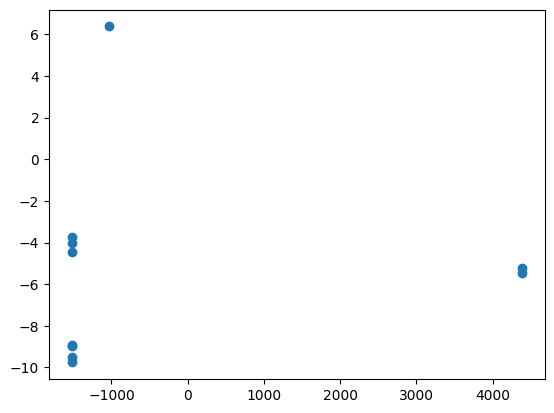

In [43]:
plt.scatter(embs_pca[:10,0], embs_pca[:10,1])

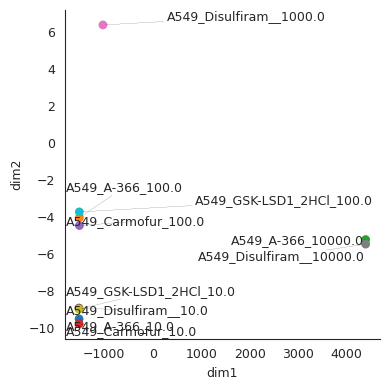

In [57]:
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

plot_embedding(embs_pca[:10], labels=list(embs.keys())[:10], show_text=True)


In [53]:
def get_palette(
        n_colors,
        palette_name='Set1'
):
    try:
        palette = sns.color_palette(palette_name)
    except:
        print('Palette not found. Using default palette tab10')
        palette = sns.color_palette()
    while len(palette) < n_colors:
        palette += palette

    return palette
    
def get_colors(
        labels,
        palette=None,
        palette_name=None
):
    n_colors = len(labels)
    if palette is None:
        palette = get_palette(n_colors, palette_name)
    col_dict = dict(zip(labels, palette[:n_colors]))
    return col_dict


def plot_embedding(
        emb,
        labels=None,
        col_dict=None,
        title=None,
        show_lines=False,
        show_text=False,
        show_legend=True,
        axis_equal=False,
        circle_size=40,
        circe_transparency=1.0,
        line_transparency=0.8,
        line_width=1.0,
        fontsize=9,
        fig_width=4,
        fig_height=4,
        file_name=None,
        file_format=None,
        labels_name=None,
        width_ratios=[7, 1],
        bbox=(1.3, 0.7)
):
    sns.set_style("white")

    # create data structure suitable for embedding
    df = pd.DataFrame(emb, columns=['dim1', 'dim2'])
    if not (labels is None):
        if labels_name is None:
            labels_name = 'labels'
        df[labels_name] = labels

    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = plt.gca()

    sns.despine(left=False, bottom=False, right=True)

    if (col_dict is None) and not (labels is None):
        col_dict = get_colors(labels)

    sns.scatterplot(
        x="dim1",
        y="dim2",
        hue=labels_name,
        palette=col_dict,
        alpha=circe_transparency,
        edgecolor="none",
        s=circle_size,
        data=df,
        ax=ax)

    try:
        ax.legend_.remove()
    except:
        pass

    if show_lines:
        for i in range(len(emb)):
            if col_dict is None:
                ax.plot(
                    [0, emb[i, 0]],
                    [0, emb[i, 1]],
                    alpha=line_transparency,
                    linewidth=line_width,
                    c=None
                )
            else:
                ax.plot(
                    [0, emb[i, 0]],
                    [0, emb[i, 1]],
                    alpha=line_transparency,
                    linewidth=line_width,
                    c=col_dict[labels[i]]
                )

    if show_text and not (labels is None):
        texts = []
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        for label in unique_labels:
            idx_label = np.where(labels == label)[0]
            texts.append(
                ax.text(
                    np.mean(emb[idx_label, 0]),
                    np.mean(emb[idx_label, 1]),
                    label,
                    fontsize=fontsize
                )
            )

        adjust_text(
            texts,
            arrowprops=dict(arrowstyle='-', color='black', lw=0.1),
            ax=ax
        )

    if axis_equal:
        ax.axis('equal')
        ax.axis('square')

    if title:
        ax.set_title(title, fontsize=fontsize, fontweight="bold")

    ax.set_xlabel('dim1', fontsize=fontsize)
    ax.set_ylabel('dim2', fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)

    plt.tight_layout()